# Creating ARIMA Model for Time Series Forecasting in Python

ARIMA stands for AutoRegressive Integrated Moving Average and represents a cornerstone in time series forecasting. It is a statistical method that has gained immense popularity due to its efficacy in handling various standard temporal structures present in time series data.

## Autoregressive Integrated Moving Average Model

The ARIMA (AutoRegressive Integrated Moving Average) model stands as a statistical powerhouse for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

Let’s decode the essence of ARIMA:

AR (Autoregression): This emphasizes the dependent relationship between an observation and its preceding or ‘lagged’ observations.
I (Integrated): To achieve a stationary time series, one that doesn’t exhibit trend or seasonality, differencing is applied. It typically involves subtracting an observation from its preceding observation.
MA (Moving Average): This component zeroes in on the relationship between an observation and the residual error from a moving average model based on lagged observations.
Each of these components is explicitly specified in the model as a parameter. A standard notation is used for ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The lag order, representing the number of lag observations incorporated in the model.
d: Degree of differencing, denoting the number of times raw observations undergo differencing.
q: Order of moving average, indicating the size of the moving average window.
A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

Interestingly, any of these parameters can be set to 0. Such configurations enable the ARIMA model to mimic the functions of simpler models like ARIMA, AR, I, or MA.

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious but helps to motivate the need to confirm the assumptions of the model in the raw observations and the residual errors of forecasts from the model.

## Green Construct Sales Dataset

We will use one of my personal datasets that I had previously created which represents sales data from Green Construct Co. (an imaginary company ) Data file includes sales information for for 4 years with product group and region details.

### Loading and Visualizing the Dataset:

In [22]:
# import necessary libraries
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# load our dataset
gc_sales = pd.read_csv("https://raw.githubusercontent.com/mdagteki/data_sources/main/GreenConstruct/GreenConstruct_Sales_Dataset.csv", index_col=[0,1], parse_dates=[0])
gc_sales.head()

C:\Users\mdagt\AppData\Local\Temp\ipykernel_20672\1363243772.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  gc_sales = pd.read_csv("https://raw.githubusercontent.com/mdagteki/data_sources/main/GreenConstruct/GreenConstruct_Sales_Dataset.csv", index_col=[0,1], parse_dates=[0])


,,Acessories,Construction Parts,Pipes,Tubes
Month,Region,,,,
2013-01-01,Central,0.00,28493.63,0.00,2467.2
2013-02-01,Central,329.24,9171.66,8455.00,576.0
2013-03-01,Central,10698.45,23872.62,0.00,24392.1
2013-04-01,Central,0.00,81.60,0.00,108.0
2013-05-01,Central,14631.80,40566.08,77961.17,15993.0


In [23]:
# Since we only need the month and total sales columns we are going to reshape our dataframe
gc_sales_t = round(gc_sales.groupby("Month").sum(),2)
gc_sales_t["Total_Sales"] = gc_sales_t["Acessories"] + gc_sales_t["Construction Parts"] + gc_sales_t["Pipes"] + gc_sales_t["Tubes"]
gc_sales_total = gc_sales_t[["Total_Sales"]]
gc_sales_total.head()

,Total_Sales
Month,
2010-01-01,783917.73
2010-02-01,663189.54
2010-03-01,984748.51
2010-04-01,967276.35
2010-05-01,734256.45


Now lets plot our data and see how it looks like, How is our trend and seasonality going on?

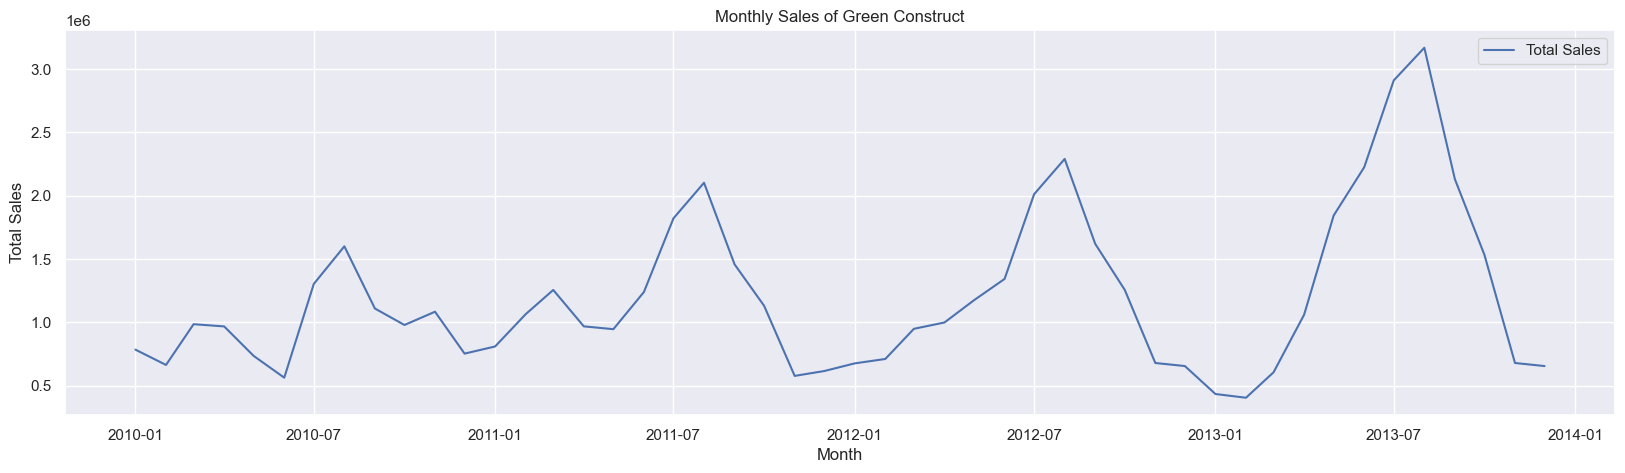

In [116]:
sns.set()
plt.figure(figsize=(20,5))
sns.lineplot(data=gc_sales_total, x=gc_sales_total.index, y="Total_Sales", label="Total Sales")
plt.title("Monthly Sales of Green Construct")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

### Model Definition
Initialize the ARIMA model by invoking ARIMA() and specifying the p, d, and q parameters.
We’ll employ the ARIMA(5,1,0) configuration:

5 lags for autoregression (AR)
1st order differencing (I)
No moving average term (MA)

In [117]:
gc_sales_total.index = gc_sales_total.index.to_period('M')
# fit model
model = ARIMA(gc_sales_total, order=(5,1,0))
model_fit = model.fit()

Running the example prints a summary of the fit model. This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

In [118]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Total_Sales   No. Observations:                   48
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -668.373
Date:                Fri, 05 Jan 2024   AIC                           1348.747
Time:                        21:20:24   BIC                           1359.848
Sample:                    01-31-2010   HQIC                          1352.924
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3121      0.241      1.296      0.195      -0.160       0.784
ar.L2         -0.0776      0.156     -0.496      0.620      -0.384       0.229
ar.L3         -0.1472      0.264     -0.558      0.5

First, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

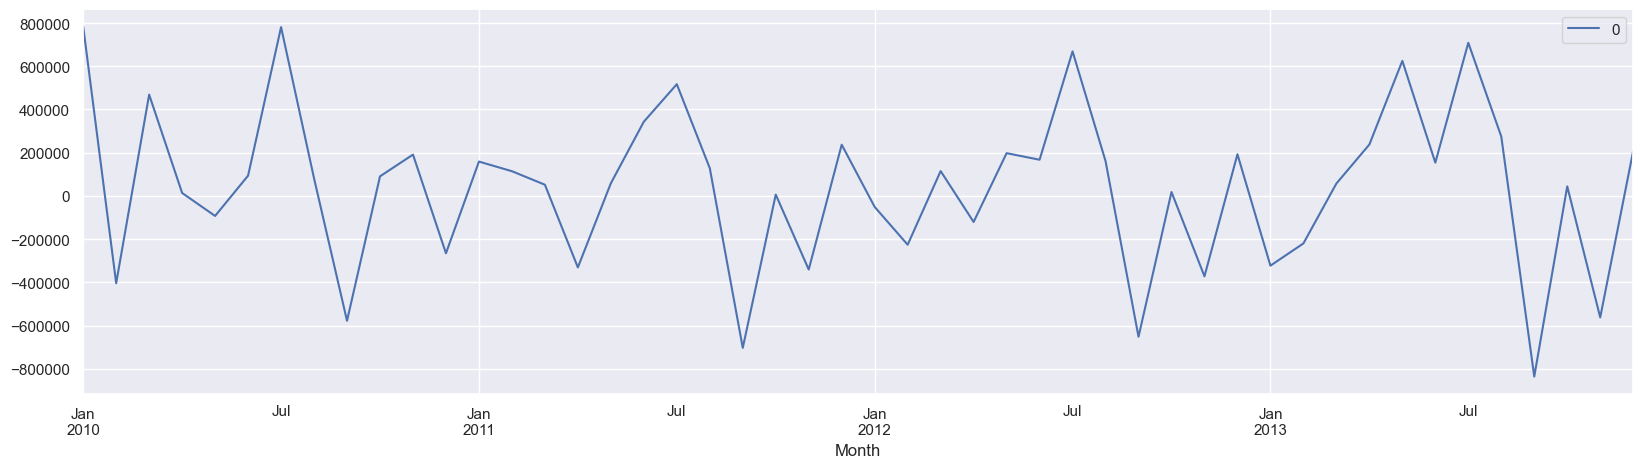

In [139]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(20,5))
plt.show()

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but may not be centred on zero.

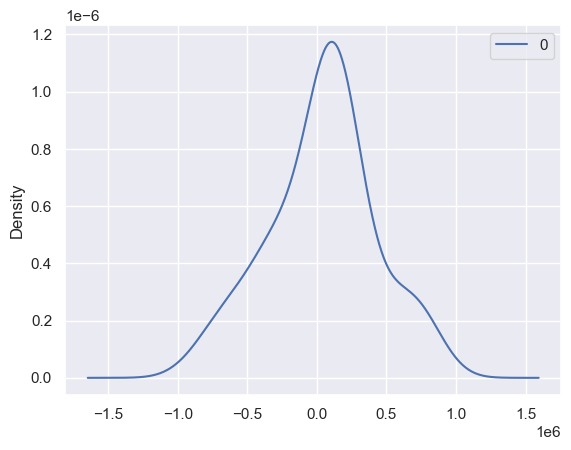

In [141]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [142]:
# summary stats of residuals
print(residuals.describe())

                   0
count      48.000000
mean    38930.406831
std    378170.068986
min   -836291.733082
25%   -221565.351765
50%     85822.210080
75%    200341.762158
max    783917.730000


### Training and Testing ARIMA Model

The ARIMA model can be used to forecast future time steps.

The ARIMA model is adept at forecasting future time points. In a rolling forecast, the model is often retrained as new data becomes available, allowing for more accurate and adaptive predictions.

We can use the predict() function on the ARIMAResults object to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

How to Forecast with ARIMA:

Use the predict() function on the ARIMAResults object. This function requires the index of the time steps for which predictions are needed.
To revert any differencing and return predictions in the original scale, set the typ argument to ‘levels’.
For a simpler one-step forecast, employ the forecast() function.
We can split the training dataset into train and test sets, use the train set to fit the model and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

In [150]:
# Split the model into train and test data sets

X = gc_sales_total.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [151]:
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

C:\Users\mdagt\AppData\Local\Temp\ipykernel_4416\2930077818.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('predicted=%f, expected=%f' % (yhat, obs))


predicted=2006147.161272, expected=2288948.220000
predicted=2192727.117226, expected=1619107.330000
predicted=1288778.287055, expected=1255213.540000
predicted=1309513.763619, expected=678578.200000
predicted=629563.477815, expected=654411.430000
predicted=851716.017481, expected=433828.520000
predicted=643048.413538, expected=404294.900000
predicted=496548.129976, expected=605215.770000
predicted=782812.232084, expected=1059743.350000
predicted=1131114.294900, expected=1842627.770000
predicted=1994967.091061, expected=2223722.380000
predicted=2153752.451183, expected=2909292.410000
predicted=3011385.413692, expected=3166493.460000
predicted=3125158.955765, expected=2129643.880000
predicted=1475276.855022, expected=1531901.020000
predicted=1378483.285058, expected=678578.200000
predicted=369825.691653, expected=654411.430000


In [154]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 475738.730


A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale.

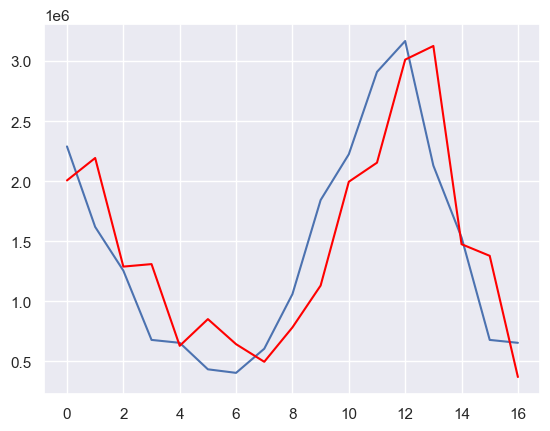

In [155]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [34]:
# Make predictions for the next 12 months
model = ARIMA(gc_sales_total, order=(5,1,0))  # Order: (p, d, q)
model_fit = model.fit()
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

c:\Users\mdagt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mdagt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mdagt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


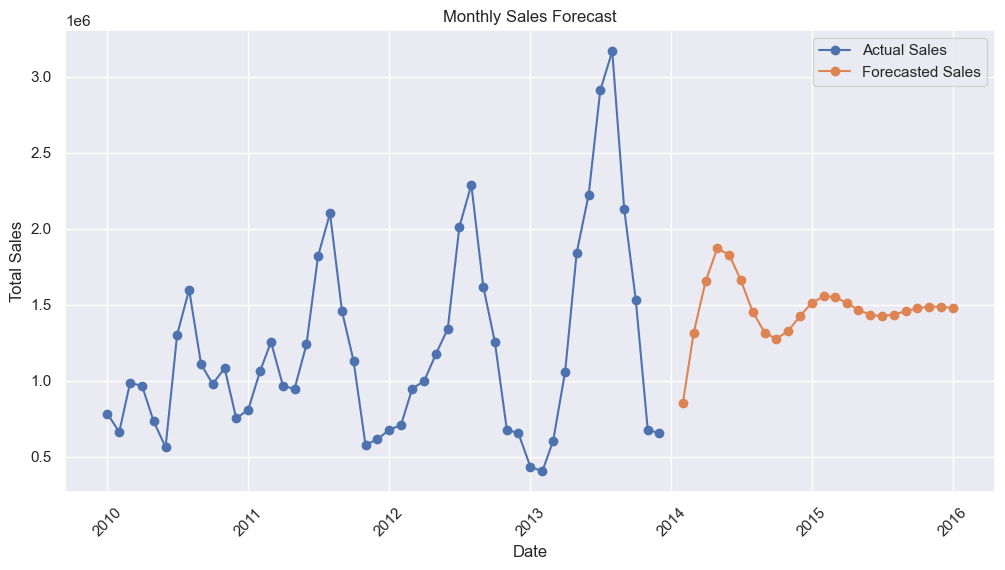

In [33]:
#Visualize the actual sales data and the forecasted values for the next months.
sns.set()
plt.figure(figsize=(12, 6))
plt.plot(gc_sales_total.index, gc_sales_total.values, marker='o', label='Actual Sales')
plt.plot(pd.date_range(start=gc_sales_total.index[-1], periods=forecast_steps+1, freq='M')[1:], forecast, marker='o', label='Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()